In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240617%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240617T131004Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db7d0b67ac66d9b02a41ed531a4937cd8f43acea1a428f553efb4ff7681a91906821cfcb23f06ae07c1b3b49acef2418c42ae4f95841a185210cbb0da1c7f0fa4785d0bddf3121c583ec18e792f4c0ad4032fb18c0e1ebbfb266e59424f6f880fe189268e239ac71d966e9c22fa9f7ae07b8d9c5e3b31125133639d3a3f97cfc9a359040748c5f746c1c170aeed26a2fea7480f5b70eb49ec621d5e3e7388141436836b59c90390b004b59ccea74662d6601942bc56f581f6173f0adf1d37f01dd409c6bb721f85b47789739acc6a06c1640146217f31c97db6f3c078898e109886a40cac26257060251ae3bdcb61eacc3be8079746af7a28098b811ff8b3ce02'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/utkface-new/utkface_aligned_cropped/crop_part1/33_1_3_20170109133043550.jpg.chip.jpg
/kaggle/input/utkface-new/utkface_aligned_cropped/crop_part1/36_0_0_20170105172611117.jpg.chip.jpg
/kaggle/input/utkface-new/utkface_aligned_cropped/crop_part1/1_0_2_20161219204418485.jpg.chip.jpg
/kaggle/input/utkface-new/utkface_aligned_cropped/crop_part1/32_1_2_20170109135854714.jpg.chip.jpg
/kaggle/input/utkface-new/utkface_aligned_cropped/crop_part1/76_1_0_20170110181730883.jpg.chip.jpg
/kaggle/input/utkface-new/utkface_aligned_cropped/crop_part1/1_1_4_20161221202153553.jpg.chip.jpg
/kaggle/input/utkface-new/utkface_aligned_cropped/crop_part1/16_0_3_20170110232812662.jpg.chip.jpg
/kaggle/input/utkface-new/utkface_aligned_cropped/crop_part1/53_1_0_20170109142039096.jpg.chip.jpg
/kaggle/input/utkface-new/utkface_aligned_cropped/crop_part1/2_1_0_20161219154620268.jpg.chip.jpg
/kaggle/input/utkface-new/utkface_aligned_cropped/crop_part1/

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Input

### Loading Dataset

In [4]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace/'

In [5]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR,filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
data = {
    'image_path' : image_paths,
    'age' : age_labels,
    'gender' : gender_labels
}

df = pd.DataFrame(data)
df.head()

image_path  age  gender
0  /kaggle/input/utkface-new/UTKFace/45_0_1_20170...   45       0
1  /kaggle/input/utkface-new/UTKFace/29_0_0_20170...   29       0
2  /kaggle/input/utkface-new/UTKFace/26_1_3_20170...   26       1
3  /kaggle/input/utkface-new/UTKFace/50_0_0_20170...   50       0
4  /kaggle/input/utkface-new/UTKFace/55_0_0_20170...   55       0

In [7]:
gender_dict = {0:'Male',1:'Female'}

### Exploratory Data Analysis (EDA)

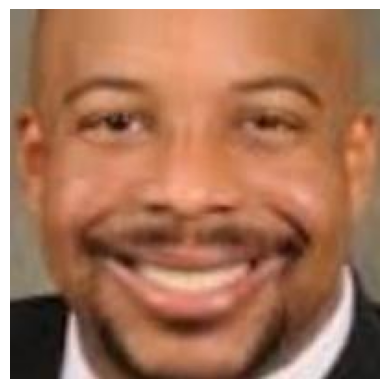

In [8]:
from PIL import Image
img = Image.open(df['image_path'][0])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

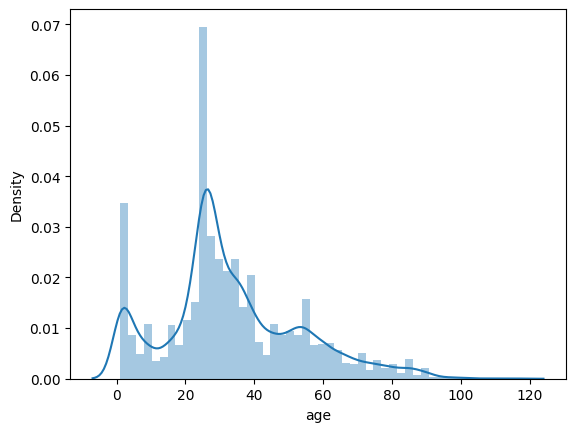

In [9]:
sns.distplot(df['age'])

<Axes: xlabel='gender'>

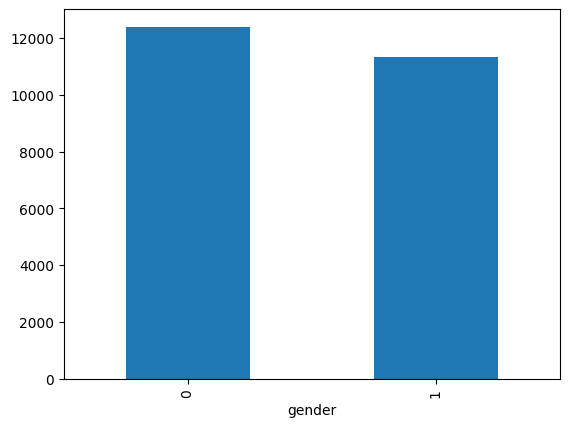

In [10]:
df['gender'].value_counts().plot(kind='bar')

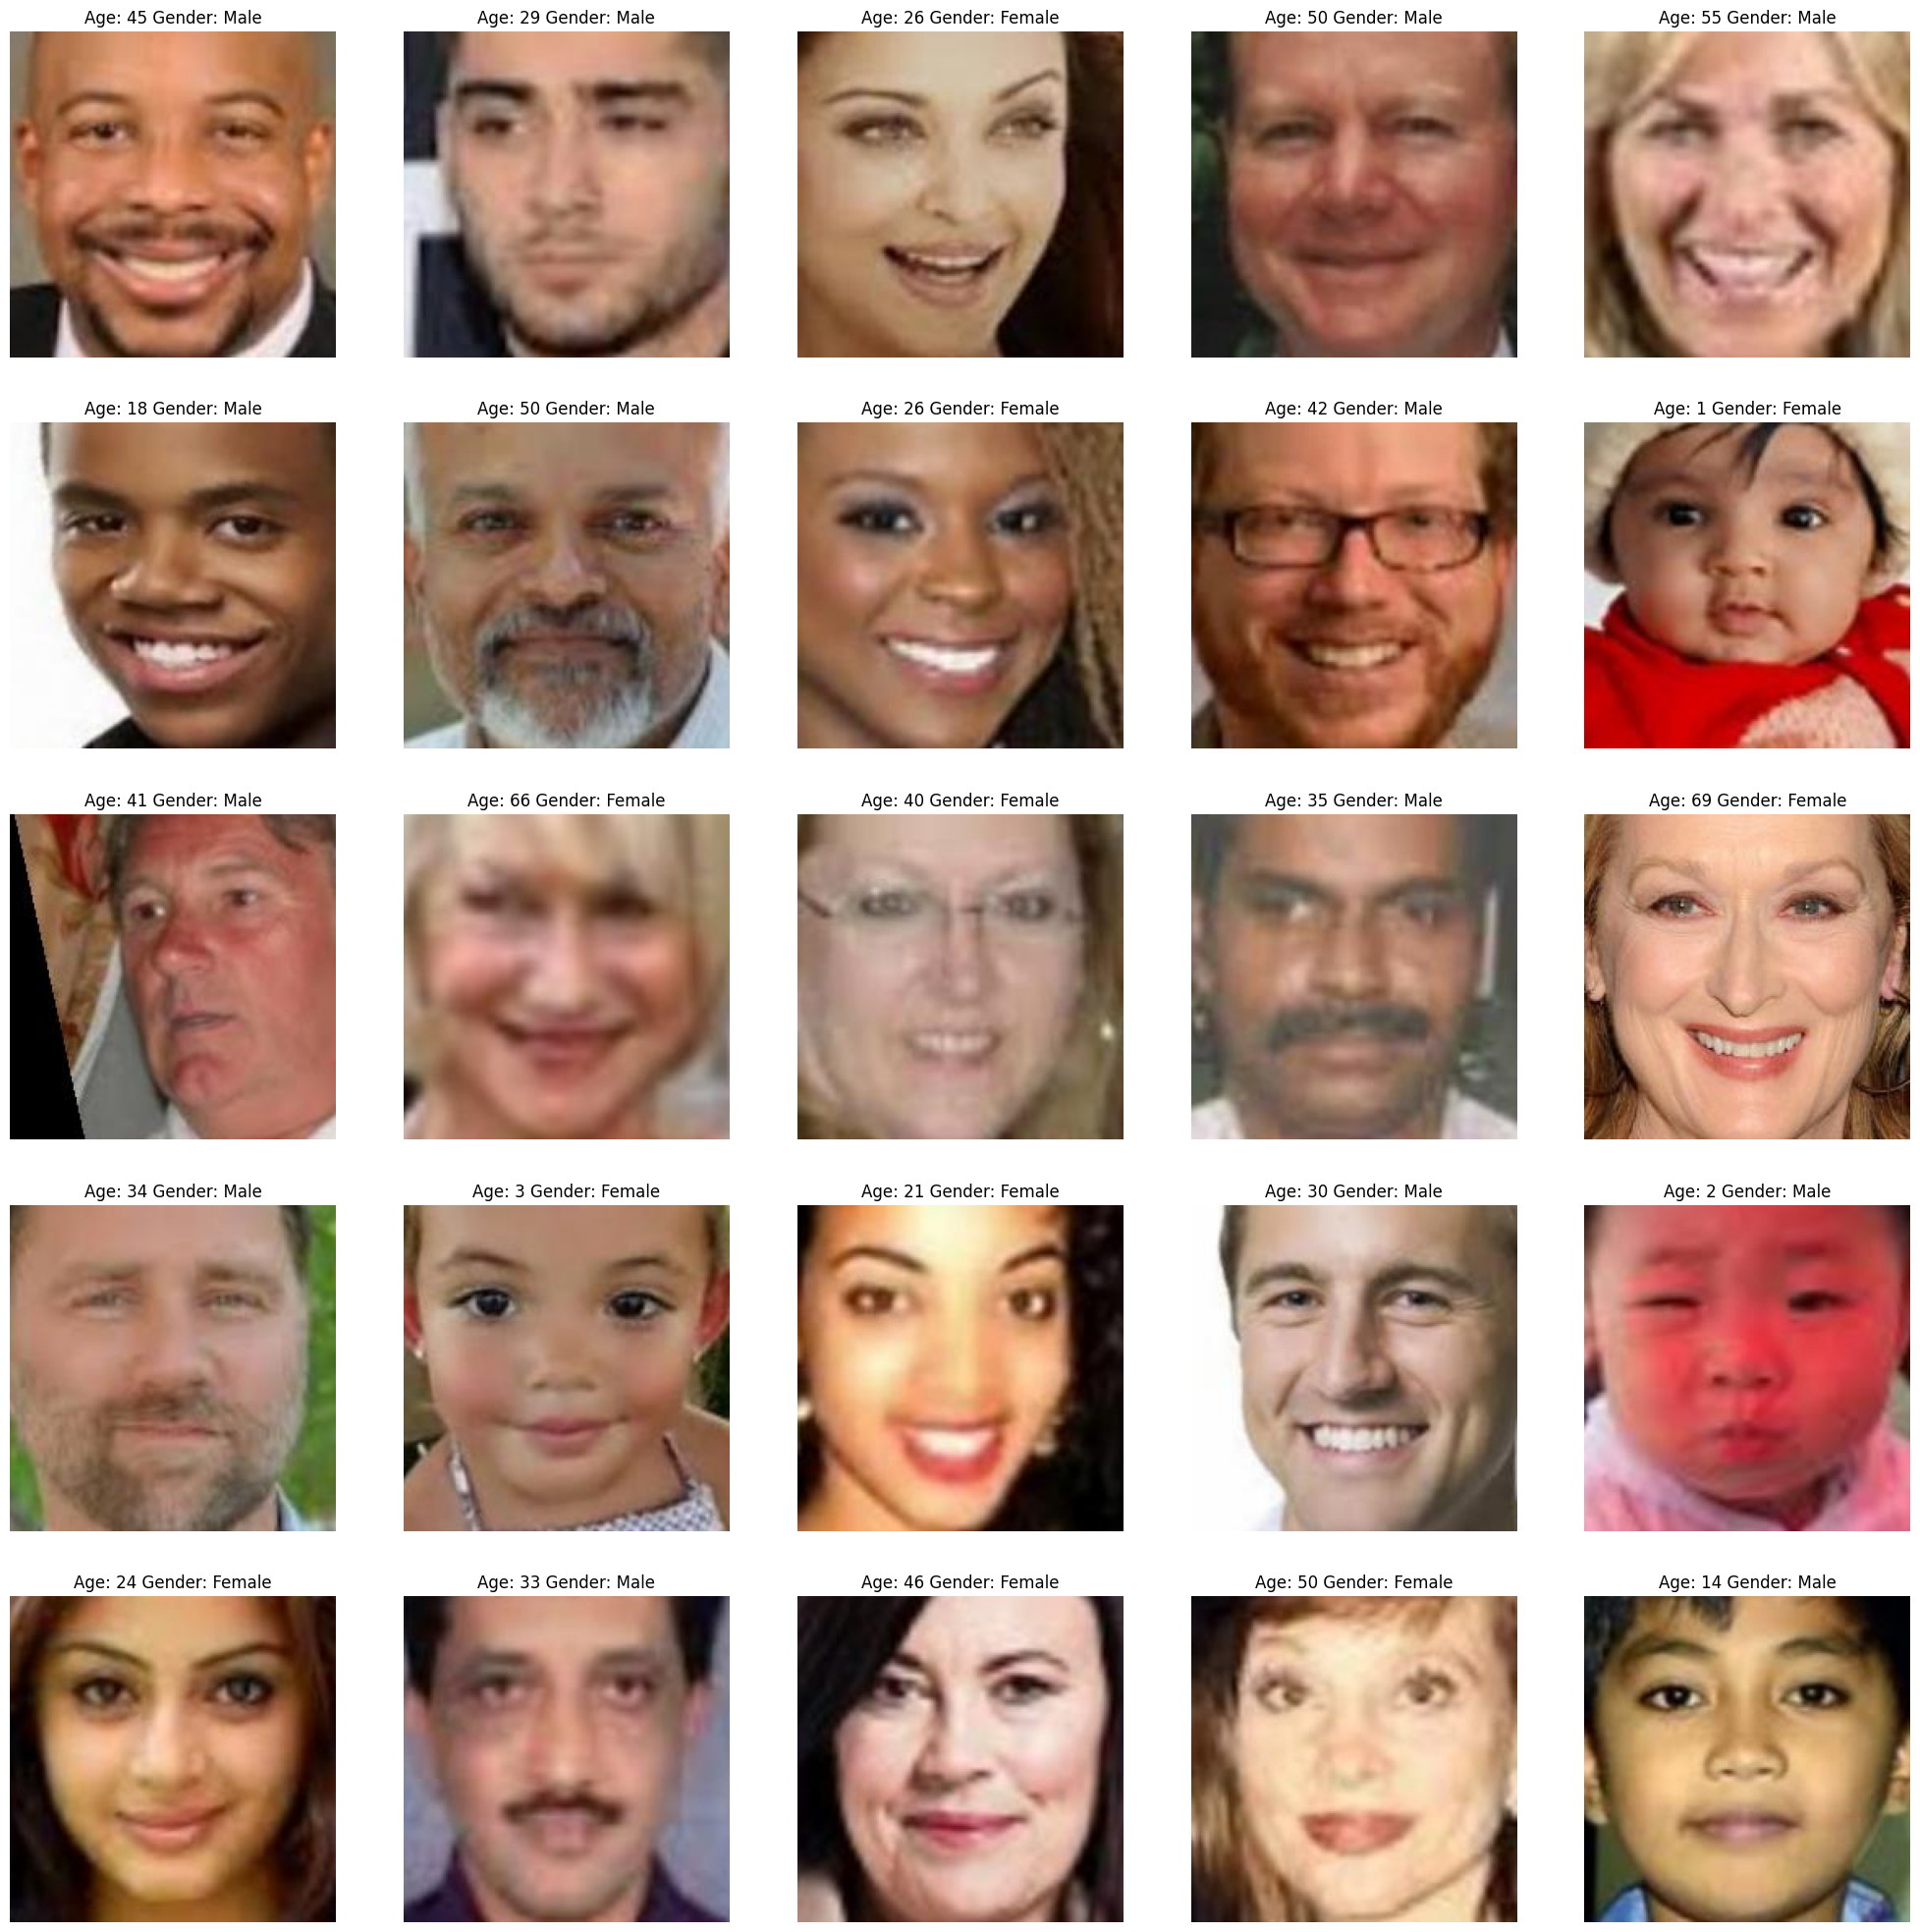

In [11]:
plt.figure(figsize=(25,25))
images = df.iloc[0:25]

for index, file, age , gender in images.itertuples():
    plt.subplot(5,5,index+1)
    img = Image.open(file)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")

### Feature Extraction

In [12]:
from keras.utils import load_img
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,color_mode='grayscale')
        img = img.resize((128,128),Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
    featues = np.array(features)
    features = np.reshape(features, (len(features), 128, 128, 1))
    return features

In [13]:
X = extract_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
X.shape

(23708, 128, 128, 1)

In [15]:
# Normalizaing the input
X = X/255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

### Model Training

In [17]:
input_shape = (128,128,1)

In [25]:
inputs = Input((input_shape))

# Convolutional Layers
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_pool1)
max_pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_pool2)
max_pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_pool3)
max_pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(max_pool4)

dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(256, activation='relu')(flatten)

drop_out1 = Dropout(0.3)(dense1)
drop_out2 = Dropout(0.3)(dense2)

output1 = Dense(1, activation='sigmoid', name='gender_out')(drop_out1)
output2 = Dense(1, activation=None, name='age_out')(drop_out2)  # Linear activation for regression

# Define the model with inputs and outputs
model = Model(inputs=inputs, outputs=[output1, output2])

# Compile the model
model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics={'gender_out': 'accuracy', 'age_out': 'accuracy'})

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 126, 126, 32)         320       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)           0         ['conv2d_8[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d_8[0][0]'

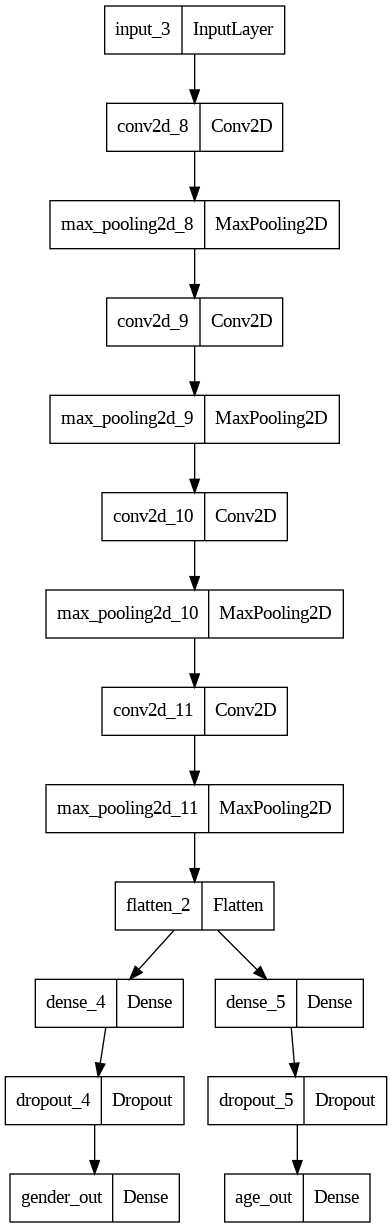

In [26]:
from keras.utils import plot_model
plot_model(model)

In [27]:
history = model.fit(
    x=X,
    y=[y_gender,y_age],
    batch_size = 32,
    epochs = 20,
    validation_split = 0.2
)

Epoch 1/20
593/593 [==============================] - 24s 24ms/step - loss: 16.0777 - gender_out_loss: 0.6996 - age_out_loss: 15.3780 - gender_out_accuracy: 0.5290 - age_out_accuracy: 0.0483 - val_loss: 13.9539 - val_gender_out_loss: 0.6098 - val_age_out_loss: 13.3441 - val_gender_out_accuracy: 0.6658 - val_age_out_accuracy: 0.0432
Epoch 2/20
593/593 [==============================] - 12s 21ms/step - loss: 12.0726 - gender_out_loss: 0.5300 - age_out_loss: 11.5426 - gender_out_accuracy: 0.7387 - age_out_accuracy: 0.0443 - val_loss: 11.3609 - val_gender_out_loss: 0.4668 - val_age_out_loss: 10.8941 - val_gender_out_accuracy: 0.7649 - val_age_out_accuracy: 0.0426
Epoch 3/20
593/593 [==============================] - 13s 21ms/step - loss: 10.1158 - gender_out_loss: 0.4391 - age_out_loss: 9.6767 - gender_out_accuracy: 0.7944 - age_out_accuracy: 0.0436 - val_loss: 9.3996 - val_gender_out_loss: 0.3787 - val_age_out_loss: 9.0209 - val_gender_out_accuracy: 0.8248 - val_age_out_accuracy: 0.0420
E

### Plotting the Results

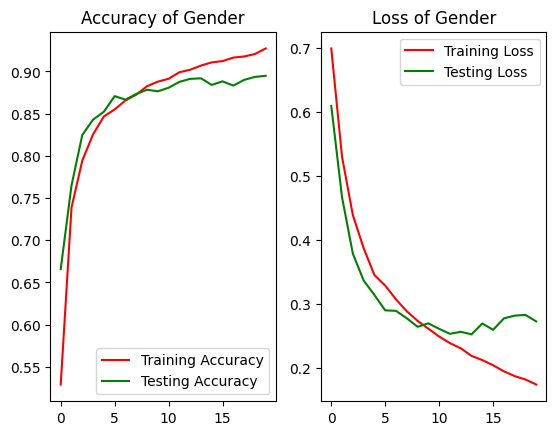

In [28]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']

plt.subplot(1,2,1)
plt.title("Accuracy of Gender")
plt.plot(acc,'r',label='Training Accuracy')
plt.plot(val_acc,'g',label='Testing Accuracy')
plt.legend()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.subplot(1,2,2)
plt.title("Loss of Gender")
plt.plot(loss,'r',label='Training Loss')
plt.plot(val_loss,'g',label='Testing Loss')
plt.legend()

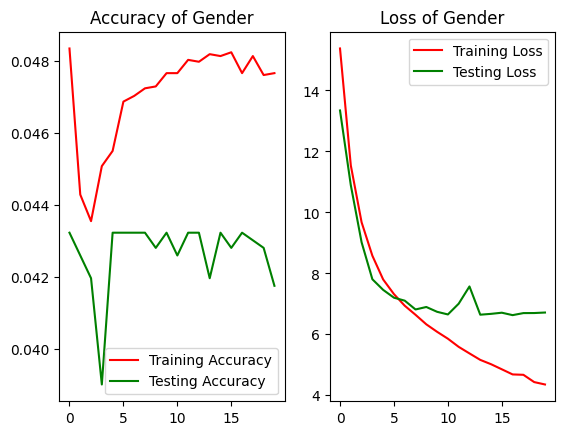

In [29]:
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']

plt.subplot(1,2,1)
plt.title("Accuracy of Gender")
plt.plot(acc,'r',label='Training Accuracy')
plt.plot(val_acc,'g',label='Testing Accuracy')
plt.legend()

loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']

plt.subplot(1,2,2)
plt.title("Loss of Gender")
plt.plot(loss,'r',label='Training Loss')
plt.plot(val_loss,'g',label='Testing Loss')
plt.legend()

### Making Predictions

Actual Age:  21  Gender:  Male
1/1 [==============================] - 0s 435ms/step
Actual Age:  23  Gender:  Male


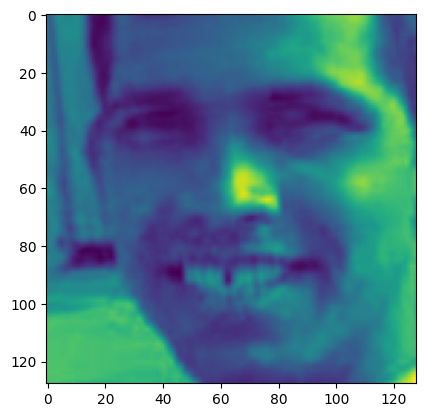

In [30]:
image_index = 152
print("Actual Age: ",y_age[image_index]," Gender: ",gender_dict[y_gender[image_index]])
y_pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(y_pred[0][0][0])]
pred_age = round(y_pred[1][0][0])
print("Actual Age: ",pred_age," Gender: ",pred_gender)
plt.imshow(X[image_index])

Actual Age:  3  Gender:  Male
1/1 [==============================] - 0s 17ms/step
Actual Age:  2  Gender:  Male


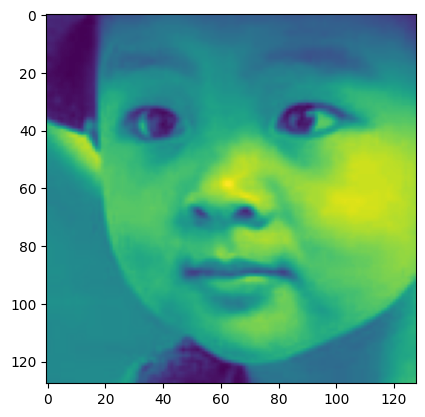

In [31]:
image_index = 485
print("Actual Age: ",y_age[image_index]," Gender: ",gender_dict[y_gender[image_index]])
y_pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(y_pred[0][0][0])]
pred_age = round(y_pred[1][0][0])
print("Actual Age: ",pred_age," Gender: ",pred_gender)
plt.imshow(X[image_index])

Actual Age:  32  Gender:  Female
1/1 [==============================] - 0s 17ms/step
Actual Age:  31  Gender:  Female


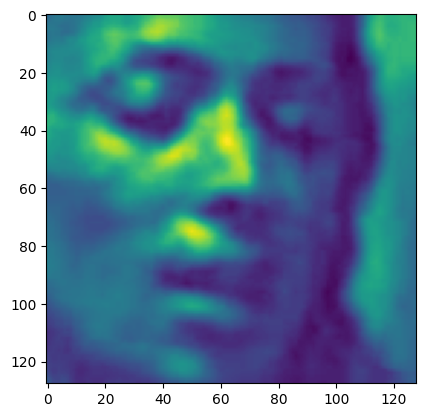

In [32]:
image_index = 5000
print("Actual Age: ",y_age[image_index]," Gender: ",gender_dict[y_gender[image_index]])
y_pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(y_pred[0][0][0])]
pred_age = round(y_pred[1][0][0])
print("Actual Age: ",pred_age," Gender: ",pred_gender)
plt.imshow(X[image_index])

In [33]:
model.export('Gender Age Prediction Model')

Saved artifact at 'Gender Age Prediction Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_3')
Output Type:
  List[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  136630019198288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630019210784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630019205152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630019197232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630018814048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630019195472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630018354944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630015471536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630019207440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13663002075336

In [34]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
shutil.make_archive('/content/Gender Age Prediction Model', 'zip', '/content/Gender Age Prediction Model')
shutil.move('/content/Gender Age Prediction Model.zip', '/content/drive/My Drive/')

drive.flush_and_unmount()

Mounted at /content/drive
